<a href="https://colab.research.google.com/github/florianrougier/stocks_analysis/blob/master/Netflix_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


We will explore Netflix Stock Price using several regression models:

1.   Ridge Regression
2.   Gradient Boosting Trees
3.   Neural Networks with 1D convolutional and LSTM layers


In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

Using TensorFlow backend.


We will load the Neflix csv file from github using the link to the raw version on the file.
[3 ways to import a csv file in google colab](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92)

In [0]:
url = 'https://raw.githubusercontent.com/florianrougier/stocks_analysis/master/data/NFLX.csv'

# We store the dataset in a pandas dataframe
df = pd.read_csv(url)

We then set the date as the independent variable and look at the first few entries

In [3]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-07,342.200012,355.750000,341.250000,348.679993,348.679993,9105800
2018-09-10,352.269989,352.500000,343.079987,348.410004,348.410004,5752200
2018-09-11,344.670013,356.149994,343.899994,355.929993,355.929993,6198100
2018-09-12,359.079987,370.429993,356.239990,369.950012,369.950012,10480800
2018-09-13,371.910004,374.089996,366.839996,368.149994,368.149994,8366100


Draw a graph of Netflix stock evolution

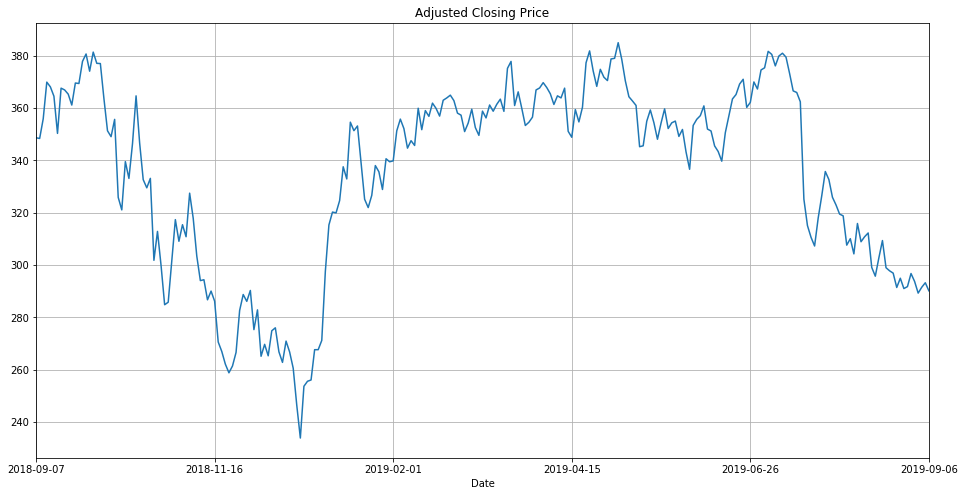

In [4]:
df['Adj Close'].plot(label='NFLX', figsize=(16,8), title="Adjusted Closing Price", grid= True)

Instead of using the date to predict stock prices, we will use batches of 32 prices from the past to predict the price on the 33rd day.

We thus have N-32 training examples with N being the nimber of days we've downloaded for the stock data.


---


TODO:
- try to change the number of days (try 16 or 64 to see if we can get better results)

In [0]:
window_size = 32 # To look at 32 days into the past

num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [0]:
data = df['Adj Close'].values[indices]

In [0]:
X = data[:,:-1]
y = data[:,-1]

In [0]:
# Train Test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train  = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

## Method 1: Ridge Regression




In [0]:
# Train 
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

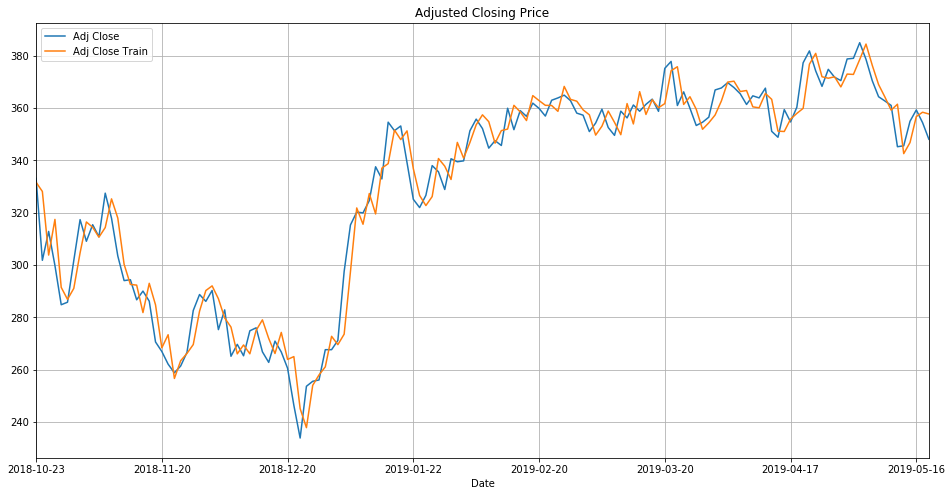

In [18]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet 
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='NFLX', figsize=(16,8), title="Adjusted Closing Price", grid=True)

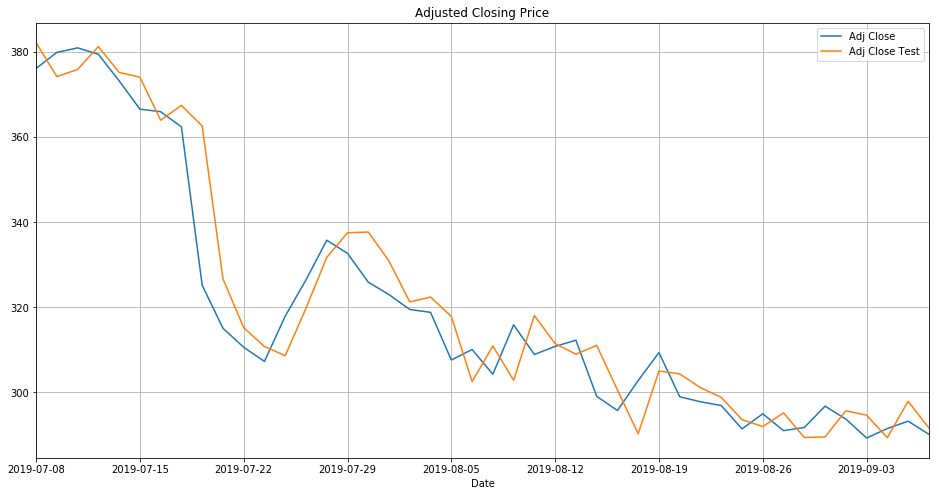

In [20]:
# On The Test set
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet 
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='NFLX', figsize=(16,8), title="Adjusted Closing Price", grid=True)

## Method 2: Gradient Boosting Trees

In [0]:
# Model 2: Gradient Boosting Trees with default parameters
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

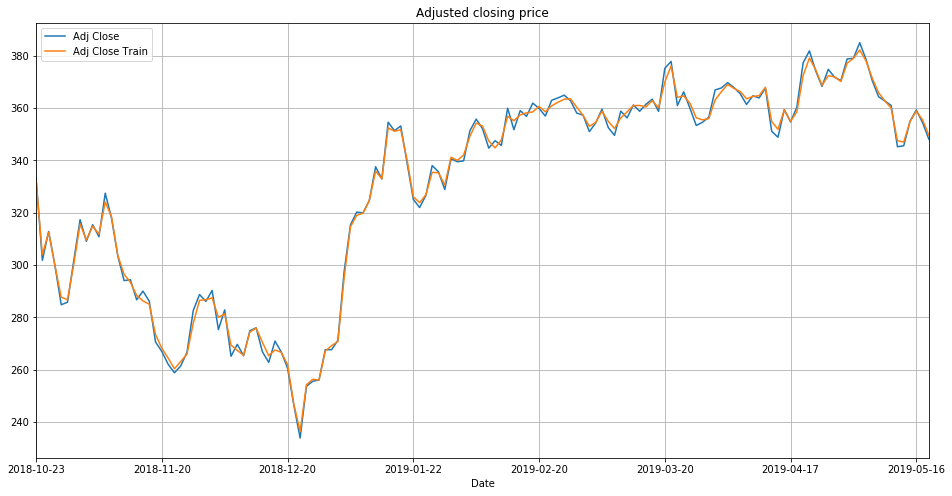

In [29]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='NFLX', figsize=(16,8), title="Adjusted closing price", grid=True)

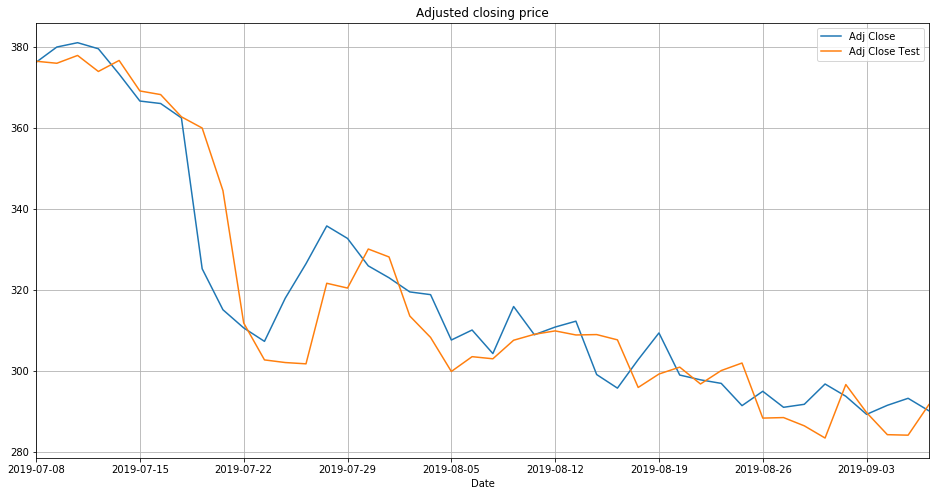

In [30]:
# Same with the test set
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='NFLX', figsize=(16,8), title="Adjusted closing price", grid=True)

## Method 3: Neural networks with 1D convolutional and LSTM layers

In [32]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)             

This is a technique to find the optimal learning rate for the neural network.  Specifically we gradually increase the learning rate at each epoch, recording the loss for each then choosing the learning rate that has the smallest loss overall.

Also, neural networks learn better when the data is normalized so we will normalize the data to the $[-1,1]$ range by using Scikit-learn's `MinMaxScaler`.  Therefore, we need to find apply this scaling on all of the price data, then decompose it into the training and test sets again.

In [33]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

In [34]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 175 samples, validate on 44 samples
Epoch 1/250
175/175 [==============================] - 3s 18ms/step - loss: 0.1531 - mean_absolute_error: 0.5168 - val_loss: 0.0649 - val_mean_absolute_error: 0.2527
Epoch 2/250
175/175 [==============================] - 0s 3ms/step - loss: 0.1531 - mean_absolute_error: 0.5168 - val_loss: 0.0649 - val_mean_absolute_error: 0.2527
Epoch 3/250
175/175 [==============================] - 0s 3ms/step - loss: 0.1531 - mean_absolute_error: 0.5168 - val_loss: 0.0649 - val_mean_absolute_error: 0.2527
Epoch 4/250
175/175 [==============================] - 0s 3ms/step - loss: 0.1531 - mean_absolute_error: 0.5168 - val_loss: 0.0649 - val_mean_absolute_error: 0.2527
Epoch 5/250
175/175 [==============================] - 0s 3ms/step - loss: 0.1531 - mean_absolute_error: 0.5168 - val_loss: 0.0649 - val_mean_absolute_error: 0.2527
Epoch 6/250
175/175 [============

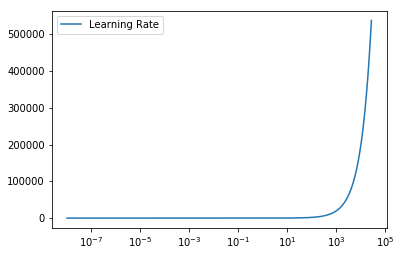

In [35]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

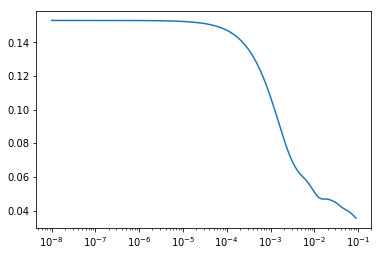

In [36]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

In [37]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 175 samples, validate on 44 samples
Epoch 1/250
175/175 [==============================] - 3s 16ms/step - loss: 0.1682 - mean_absolute_error: 0.5396 - val_loss: 0.0636 - val_mean_absolute_error: 0.3235
Epoch 2/250
175/175 [==============================] - 0s 3ms/step - loss: 0.0985 - mean_absolute_error: 0.3941 - val_loss: 0.1436 - val_mean_absolute_error: 0.4973
Epoch 3/250
175/175 [==============================] - 0s 3ms/step - loss: 0.0925 - mean_absolute_error: 0.2931 - val_loss: 0.2114 - val_mean_absolute_error: 0.5998
Epoch 4/250
175/175 [==============================] - 0s 3ms/step - loss: 0.1140 - mean_absolute_error: 0.3765 - val_loss: 0.1313 - val_mean_absolute_error: 0.4685
Epoch 5/250
175/175 [==============================] - 0s 3ms/step - loss: 0.0671 - mean_absolute_error: 0.2741 - val_loss: 0.0427 - val_mean_absolute_error: 0.2574
Epoch 6/250
175/175 [==============================] - 0s 3ms/step - loss: 0.0464 - mean_absolute_error: 0.2397 - val_loss: 0.027

Once we predict the values, we also must *reverse* the normalization so that we can plot the predictions in the same scale as the original values.

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

Let's now plot what the training and test predictions look like and compare with the original values.

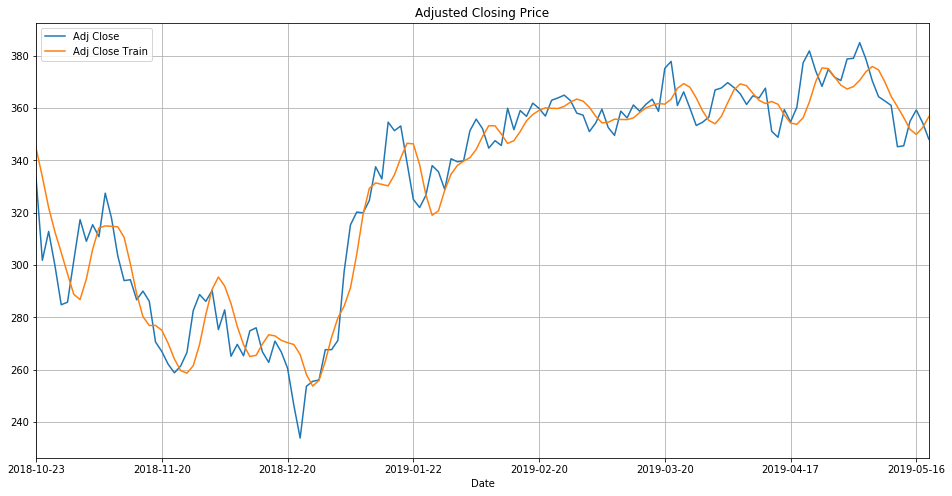

In [40]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='NFLX', figsize=(16,8), title='Adjusted Closing Price', grid=True)

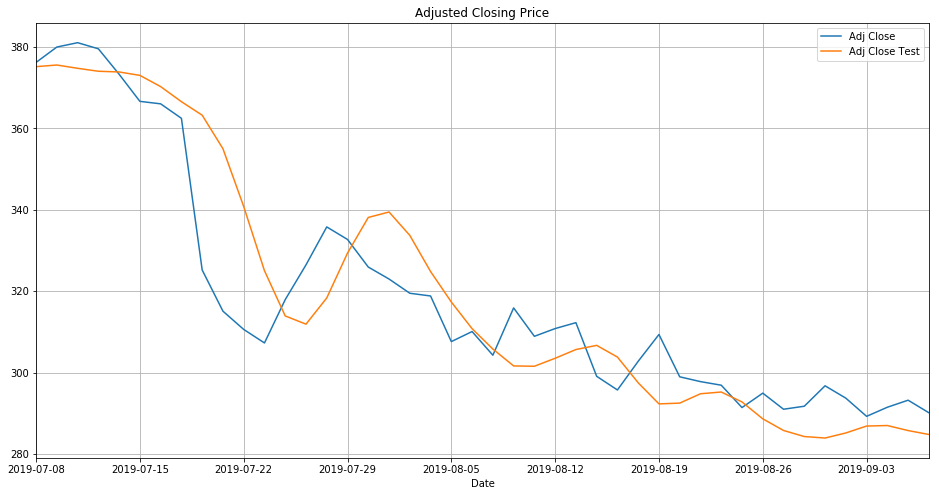

In [41]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

I have more confidence in the neural network approach as it seems to indicate what the trend would be like when the data is noise free.  We can also see a more smoother transition between points of high curvature.

Finally to see how everything performs, let's plot all of the methods together for both the training and testing data.

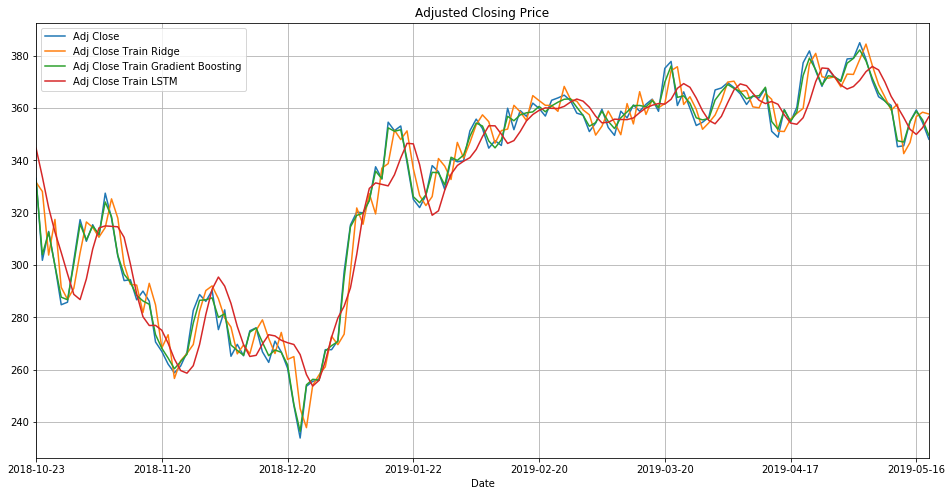

In [42]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='NFLX', figsize=(16,8), title='Adjusted Closing Price', grid=True)


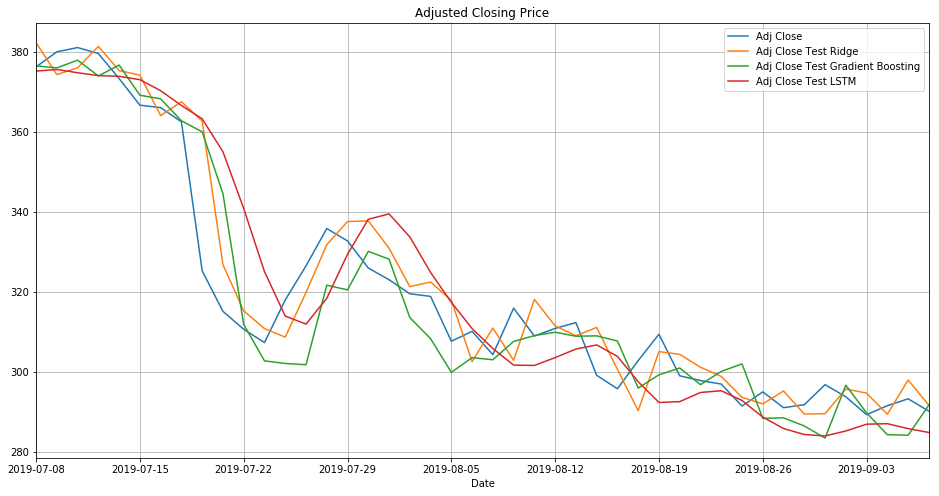

In [43]:
# With testing data
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

So here's where it gets interesting.  We can see that the neural network based method is what the values would be when there's no presence of noise.  The ridge regression based method seems to follow the trend the best with the noise modelled in.  The gradient boosting method also follows the same trend, but because the method does not use interpolation, points of very high curvature tend to be the most inaccurate.

## How can we predict future price if we do not have the stock price information for the last 32 days ?
Good question. What you can do take the learned model that you have, then start with the last  𝑁  values in your data (in my case 32), and start predicting what the next values will be. With the next values, keep using the previous  𝑁  values for your desired forecasting.

We already have our learned models above, so let's go ahead and do that.

In [0]:
num_days = 10 # Let's try and forecase the next 10 days

# Get the last window_size (32) days
data_seed = df['Adj Close'].values[-window_size:][None]
# Get the normalized data as well for the neural network
data_seed_norm = scaler.transform(data_seed)
input_values = {"ridge": data_seed, "gb": data_seed, "keras": data_seed_norm.copy()}
values = {"ridge": [], "gb": [], "keras": []}
for i in range(num_days): # For each day...
    # Predict the next price given the previous N prices
    values["ridge"].append(ridge_model.predict(input_values["ridge"])[0])
    values["gb"].append(gb_model.predict(input_values["gb"])[0])
    values["keras"].append(keras_model.predict(input_values["keras"][...,None])[0][0])

    # Dump the oldest price and put the newest price at the end
    for v in input_values:
        val = input_values[v]
        val = np.insert(val, -1, values[v][-1], axis=1)
        val = np.delete(val, 0, axis=1)
        input_values[v] = val.copy()

# Convert all to NumPy arrays
for v in input_values:
    values[v] = np.array(values[v])

# Unnormalize prices from NN approach
values["keras"] = scaler.inverse_transform(values["keras"][None])[0]
    

Now let's plot the next 10 days worth of data

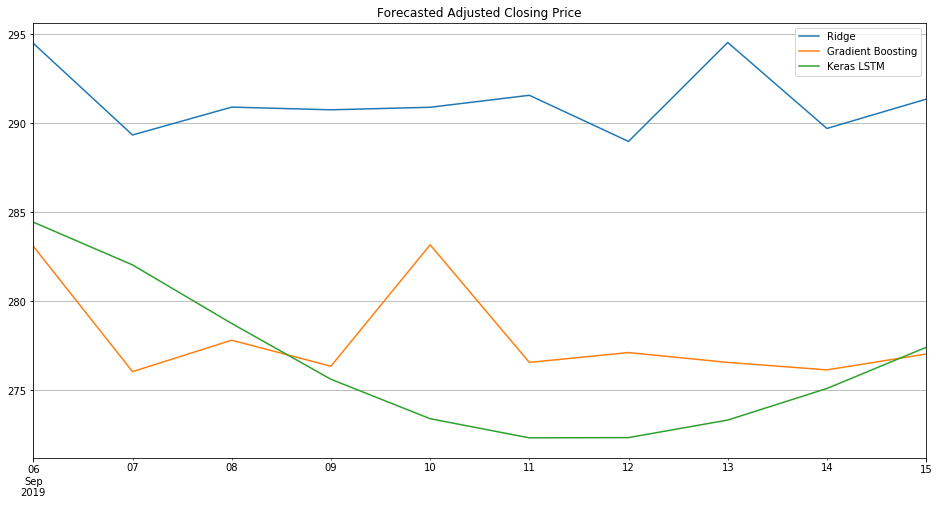

In [45]:
from datetime import timedelta, datetime
last_date = datetime.strptime(df.index[-1], '%Y-%m-%d')
df_forecast = pd.DataFrame()
df_forecast["Ridge"] = values["ridge"]
df_forecast["Gradient Boosting"] = values["gb"]
df_forecast["Keras LSTM"] = values["keras"]
df_forecast.index = pd.date_range(start=last_date, periods=num_days)
df_forecast.plot(label='TSLA', figsize=(16,8), title='Forecasted Adjusted Closing Price', grid=True)

Do the same thing for the next 2 months

In [0]:
num_days = 60 # Let's try and forecase the next 60 days

# Get the last window_size (32) days
data_seed = df['Adj Close'].values[-window_size:][None]
# Get the normalized data as well for the neural network
data_seed_norm = scaler.transform(data_seed)
input_values = {"ridge": data_seed, "gb": data_seed, "keras": data_seed_norm.copy()}
values = {"ridge": [], "gb": [], "keras": []}
for i in range(num_days): # For each day...
    # Predict the next price given the previous N prices
    values["ridge"].append(ridge_model.predict(input_values["ridge"])[0])
    values["gb"].append(gb_model.predict(input_values["gb"])[0])
    values["keras"].append(keras_model.predict(input_values["keras"][...,None])[0][0])

    # Dump the oldest price and put the newest price at the end
    for v in input_values:
        val = input_values[v]
        val = np.insert(val, -1, values[v][-1], axis=1)
        val = np.delete(val, 0, axis=1)
        input_values[v] = val.copy()

# Convert all to NumPy arrays
for v in input_values:
    values[v] = np.array(values[v])

# Unnormalize prices from NN approach
values["keras"] = scaler.inverse_transform(values["keras"][None])[0]

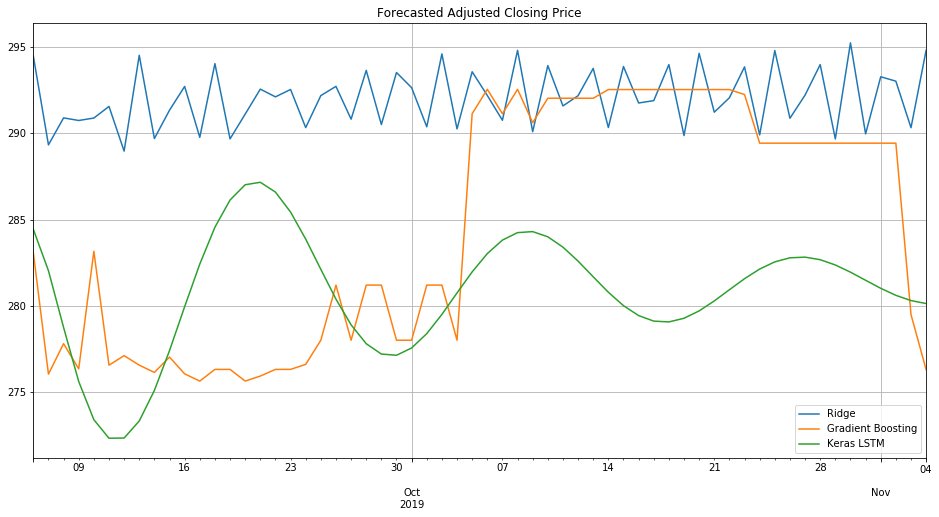

In [47]:
from datetime import timedelta, datetime
last_date = datetime.strptime(df.index[-1], '%Y-%m-%d')
df_forecast = pd.DataFrame()
df_forecast["Ridge"] = values["ridge"]
df_forecast["Gradient Boosting"] = values["gb"]
df_forecast["Keras LSTM"] = values["keras"]
df_forecast.index = pd.date_range(start=last_date, periods=num_days)
df_forecast.plot(label='TSLA', figsize=(16,8), title='Forecasted Adjusted Closing Price', grid=True)

The models gives really different results. While the Ridge model gives more stable predictions overall, it gives noisy prediction on a short term period. Neural networks based model gives smoother predictions. 